In [0]:
# Cadeia de Markov Cenário 2

import pandas as pd
import numpy as np
from numpy.linalg import matrix_power
import numpy.linalg as lin
import matplotlib.pyplot as plt

In [0]:
def get_state_id(array, size):
    return tuple(array + [0]*(size - len(array)))

In [0]:
# Gera os estados adjacentes
def get_next_states(f, λ1, λ2, µ1, µ2, size):
    r = {}
    f = [i for i in f if i > 0]
    
    # Chegada de um cliente do tipo 1
    if λ1 > 0:
        r[get_state_id(f + [1], size)] = λ1
    # Chegada de um cliente do tipo 2
    if λ2 > 0:
        r[get_state_id(f + [2], size)] = λ2
    
    # Saida de um cliente do tipo 1
    if µ1 > 0 and len(f) > 0 and f[0] == 1:
        r[get_state_id(f[1:], size)] = µ1
    # Saida de um cliente do tipo 2
    if µ1 > 0 and len(f) > 0 and f[0] == 2:
        r[get_state_id(f[1:], size)] = µ2

    return r

In [22]:
print( get_next_states([], 0.1, 0.2, 0.3, 0.4, 3) )
print( get_next_states([], 0.0, 0.2, 0.3, 0.4, 3) )
print( get_next_states([], 0.1, 0.0, 0.3, 0.4, 3) )
print( get_next_states([1], 0.1, 0.2, 0.3, 0.4, 3) )


{(1, 0, 0): 0.1, (2, 0, 0): 0.2}
{(2, 0, 0): 0.2}
{(1, 0, 0): 0.1}
{(1, 1, 0): 0.1, (1, 2, 0): 0.2, (0, 0, 0): 0.3}


In [0]:
# Cria os estados da Cadeia de Markov
def create_ctmc_states(size, λ1, λ2, µ1, µ2):
    states = {}
    queue = [tuple([0]*size)]

    while len(queue) > 0:
        f = queue.pop(0)
        n = get_next_states(f, λ1, λ2, µ1, µ2, size)
        queue.extend([list(i) for i in n.keys() if len(i) <= size and i not in states])
        states[tuple(f)] = {k:v for (k,v) in n.items() if len(k) <= size}

    return states

In [24]:
create_ctmc_states(3, 0.6, 0.2, 1, 0.5)

{(0, 0, 0): {(1, 0, 0): 0.6, (2, 0, 0): 0.2},
 (1, 0, 0): {(0, 0, 0): 1, (1, 1, 0): 0.6, (1, 2, 0): 0.2},
 (1, 1, 0): {(1, 0, 0): 1, (1, 1, 1): 0.6, (1, 1, 2): 0.2},
 (1, 1, 1): {(1, 1, 0): 1},
 (1, 1, 2): {(1, 2, 0): 1},
 (1, 2, 0): {(1, 2, 1): 0.6, (1, 2, 2): 0.2, (2, 0, 0): 1},
 (1, 2, 1): {(2, 1, 0): 1},
 (1, 2, 2): {(2, 2, 0): 1},
 (2, 0, 0): {(0, 0, 0): 0.5, (2, 1, 0): 0.6, (2, 2, 0): 0.2},
 (2, 1, 0): {(1, 0, 0): 0.5, (2, 1, 1): 0.6, (2, 1, 2): 0.2},
 (2, 1, 1): {(1, 1, 0): 0.5},
 (2, 1, 2): {(1, 2, 0): 0.5},
 (2, 2, 0): {(2, 0, 0): 0.5, (2, 2, 1): 0.6, (2, 2, 2): 0.2},
 (2, 2, 1): {(2, 1, 0): 0.5},
 (2, 2, 2): {(2, 2, 0): 0.5}}

In [0]:
# Gera a matriz referente a Cadeia de Markov
def create_ctmc_matrix(size, λ1, λ2, µ1, µ2):
    states = create_ctmc_states(size, λ1, λ2, µ1, µ2)
    df = pd.DataFrame(states)
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.sort_index()
    df = df.transpose()
    df = df[df.index]
    columns = df.columns
    np.fill_diagonal(df.values, -df.sum(axis=1))
    df = df.fillna(0)
    return df.to_numpy(), columns

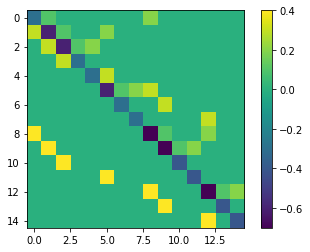

In [26]:
Q, columns = create_ctmc_matrix(3, 0.1, 0.2, 0.3, 0.4)
plt.imshow(Q)
plt.colorbar()

In [0]:
def get_ctmc_steady_state(Q):
    sz = Q.shape[0]
    Qt = Q.transpose()
    Qt[sz-1,:] = 1
    b = np.zeros((sz,1))
    b[sz-1] = 1
    x = lin.solve(Qt, b)
    return x

In [0]:
def get_pi_N(steady_state, states):
    df_steady_state = pd.DataFrame(steady_state, index=states)
    get_N_from_state = lambda ix: sum(x > 0 for x in ix)
    df_steady_state_N = df_steady_state.set_index(df_steady_state.index.map(get_N_from_state))
    df_steady_state_N = df_steady_state_N.groupby(df_steady_state_N.index).agg(sum)
    return df_steady_state_N[0].reindex(range(df_steady_state_N[0].index.max() + 1)).ffill(0).to_numpy()

In [29]:
π = get_ctmc_steady_state(Q)
π

array([[0.32325084],
       [0.09838069],
       [0.02871983],
       [0.00957328],
       [0.01914655],
       [0.05743966],
       [0.01914655],
       [0.03829311],
       [0.16865261],
       [0.04521845],
       [0.01130461],
       [0.02260923],
       [0.09043691],
       [0.02260923],
       [0.04521845]])

In [30]:
get_pi_N(π, columns)

array([0.32325084, 0.2670333 , 0.22181485, 0.18790101])

In [0]:
def calculaCadeiaMarkovCenario2(λ1, sz):
    print("create_ctmc_matrix")
    λ2 = 0.2
    µ1 = 1
    µ2 = 0.5
    Q, columns = create_ctmc_matrix(sz, λ1, λ2, µ1, µ2)
    print("get_ctmc_stationary_state")
    π = get_ctmc_steady_state(Q)
    print("get_pi_N")
    πk = get_pi_N(π, columns)
    return πk

In [32]:
rho = 0.6/1 + 0.2/0.5
rho

1.0

In [33]:
πk = calculaCadeiaMarkovCenario2(0.6, 10)

create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N


πk = [0.09844714 0.09352478 0.09089952 0.08949939 0.08875265 0.08835438
 0.08814198 0.0880287  0.08796828 0.08793606 0.09844714]
r = [0 0 1 2 3 4 5 6 7 8 9]


4.063746455965408

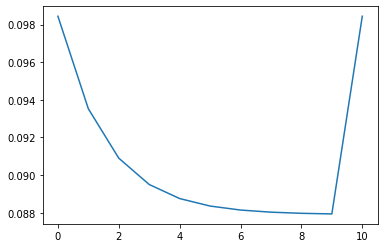

In [34]:
plt.plot(πk)
#plt.xlim(right=10)
r = np.array([0] + list(range(len(πk) - 1)))
print("πk =", πk)
print("r =", r)
πk.dot(r)

In [0]:
def CadeiaMarkovCenario2():
    Nqs = []
    W = []
    Nq = 0
    for i in np.linspace(0.05, 0.6, 12):
        print("λ1:", i)
        λ1 = i
        λ2 = 0.2
        πk = calculaCadeiaMarkovCenario2(λ1, 10)

        # Faz os cálculos dos Nq e W
        r = np.array([0] + list(range(len(πk) - 1)))
        Nq = πk.dot(r)
        Nqs.append(Nq)
        W.append(Nq/(λ1+λ2))

    return Nqs, W

In [36]:
Nqs, W = CadeiaMarkovCenario2()
print(Nqs)
print(W)

λ1: 0.05
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.1
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.15
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.2
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.25
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.3
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.35
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.39999999999999997
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.44999999999999996
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.49999999999999994
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.5499999999999999
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
λ1: 0.6
create_ctmc_matrix
get_ctmc_stationary_state
get_pi_N
[0.38415812169026686, 0.531892242935498, 0.7146974348172122, 0.9374835710105527, 1.2040737516304063, 1.5163248974147967, 1.8732511406898977, 2.270397746840788, 2.6997388042512886, 3.1502691